In [1]:
figDir = '~/Hyphosphere/data/3Exp/figures'

#work_dir = '~/Hyphosphere/data/3Exp/Composition'

# phyloseq - full object with tree (does not include archaea)
physeq_file = '~/Hyphosphere/data/3Exp/phyloseq/3Exp_phyloseq_thresh_wtree_experimental_woContam.rds'

In [2]:
library(RColorBrewer)
library(vegan)
library(ggpubr)
library(tidyr)
library(dplyr)
library(reshape2)
library(phyloseq)
library(gridExtra)
library(ggplot2)
library(foreach)
library(doParallel)


Warning message:
“package ‘RColorBrewer’ was built under R version 3.6.1”Warning message:
“package ‘vegan’ was built under R version 3.6.1”Loading required package: permute
Warning message:
“package ‘permute’ was built under R version 3.6.1”Loading required package: lattice
Warning message:
“package ‘lattice’ was built under R version 3.6.1”This is vegan 2.5-5
Loading required package: ggplot2
Warning message:
“package ‘ggplot2’ was built under R version 3.6.1”
Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
“package ‘reshape2’ was built under R version 3.6.1”
Attaching package: ‘reshape2’

The following object is masked from ‘package:tidyr’:

    smiths

Warning message:
“package ‘phyloseq’ was built under R version 3.6.1”
Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine

W

In [3]:
theme_pub = function (base_size = 8, base_family = "Helvetica") 
{
    theme_grey(base_size = base_size, base_family = base_family) %+replace% 
        theme(
            axis.line.x = element_line(size = .5),
            axis.line.y = element_line(size = .5),
            axis.text = element_text(size = base_size),
            panel.background = element_rect(fill = "white", colour = NA), 
            panel.border = element_rect(fill = NA, color = "black", size = .5), 
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(), 
            strip.background = element_rect(fill = "grey85", 
                colour = "grey20"), 
            legend.key = element_rect(fill = "white", 
                colour = NA), complete = TRUE,
            legend.text = element_text(size = base_size),
            legend.title = element_text(face = "bold"))
    
    }

In [4]:
ps = readRDS(physeq_file)
ps = subset_taxa(ps, !is.na("Phylum"))


tax_table(ps) %>% head()
ps = subset_taxa(ps, Kingdom == "Bacteria" &  !is.na(Phylum))
ps = subset_samples(ps, !SampleType %in% c("EB", "PB", "MK")) #remove non-experimental controls

# re-normalize after subsetting taxa
ps.snorm = transform_sample_counts(ps, function(x) x/sum(x))

otu_table(ps.snorm)[1:4, 1:10]
tax_table(ps.snorm) %>% tail()

ps.snorm
                                  


,Kingdom,Phylum,Class,Order,Family,Genus
ASV6971,Bacteria,NA,NA,NA,NA,NA
ASV2480,Bacteria,NA,NA,NA,NA,NA
ASV5742,Bacteria,NA,NA,NA,NA,NA
ASV15180,Bacteria,Acidobacteria,Subgroup_20,NA,NA,NA
ASV9985,Bacteria,Acidobacteria,Subgroup_20,NA,NA,NA
ASV22021,Bacteria,Acidobacteria,Subgroup_20,NA,NA,NA


,ASV15180,ASV9985,ASV22021,ASV9417,ASV20094,ASV25884,ASV14673,ASV10366,ASV30259,ASV659
1.1BP,0,0,0.0001412274,0,0,0,0,0,0,0.0006119855
1.1BS,0,0,0.0000000000,0,0,0,0,0,0,0.0011081508
1.1CH,0,0,0.0000000000,0,0,0,0,0,0,0.0002464673
1.1CS,0,0,0.0000000000,0,0,0,0,0,0,0.0006685769


,Kingdom,Phylum,Class,Order,Family,Genus
ASV2498,Bacteria,Proteobacteria,Deltaproteobacteria,Desulfarculales,Desulfarculaceae,NA
ASV11419,Bacteria,Proteobacteria,Deltaproteobacteria,Desulfarculales,Desulfarculaceae,NA
ASV5649,Bacteria,Proteobacteria,Deltaproteobacteria,Desulfarculales,Desulfarculaceae,NA
ASV22326,Bacteria,Proteobacteria,Deltaproteobacteria,Desulfarculales,Desulfarculaceae,NA
ASV7976,Bacteria,Proteobacteria,Deltaproteobacteria,Desulfarculales,Desulfarculaceae,NA
ASV10788,Bacteria,Proteobacteria,Deltaproteobacteria,Desulfarculales,Desulfarculaceae,NA


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 18707 taxa and 385 samples ]
sample_data() Sample Data:       [ 385 samples by 11 sample variables ]
tax_table()   Taxonomy Table:    [ 18707 taxa by 6 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 18707 tips and 18706 internal nodes ]

# Experiment 1 & 2 primary analysis

In [5]:
ps.s = ps.snorm %>% subset_samples(Experiment %in% c(1, 2) & SampleType %in% c("CS", "CH", "BS") & Fungus == "Gv")

In [6]:
registerDoParallel(makeCluster(20))

In [7]:
wunif.dist = phyloseq::distance(ps.s, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

#unif.dist = phyloseq::distance(ps.snorm, 
#                       method = "unifrac", 
#                       weighted = FALSE,
#                       fast = TRUE, 
#                       parallel = TRUE, 
#                       normalized = FALSE)

In [8]:
set.seed(101)

df = as(sample_data(ps.s), "data.frame")
#df$Rep = as.factor(df$Rep)
#df$TimePoint = as.factor(df$TimePoint)
d = wunif.dist

adonis.w = adonis(formula = d ~Soil + SampleType + SampleType:Soil + Experiment + Experiment:SampleType, df, permutations = 999)
print("weighted-UniFrac")
adonis.w

[1] "weighted-UniFrac"



Call:
adonis(formula = d ~ Soil + SampleType + SampleType:Soil + Experiment +      Experiment:SampleType, data = df, permutations = 999) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

                      Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
Soil                   3    1.8821 0.62736  25.202 0.30407  0.001 ***
SampleType             2    1.6141 0.80704  32.420 0.26077  0.001 ***
Experiment             1    0.3032 0.30323  12.181 0.04899  0.001 ***
Soil:SampleType        5    0.5107 0.10215   4.103 0.08252  0.001 ***
SampleType:Experiment  1    0.1121 0.11206   4.502 0.01810  0.003 ** 
Residuals             71    1.7674 0.02489         0.28555           
Total                 83    6.1896                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

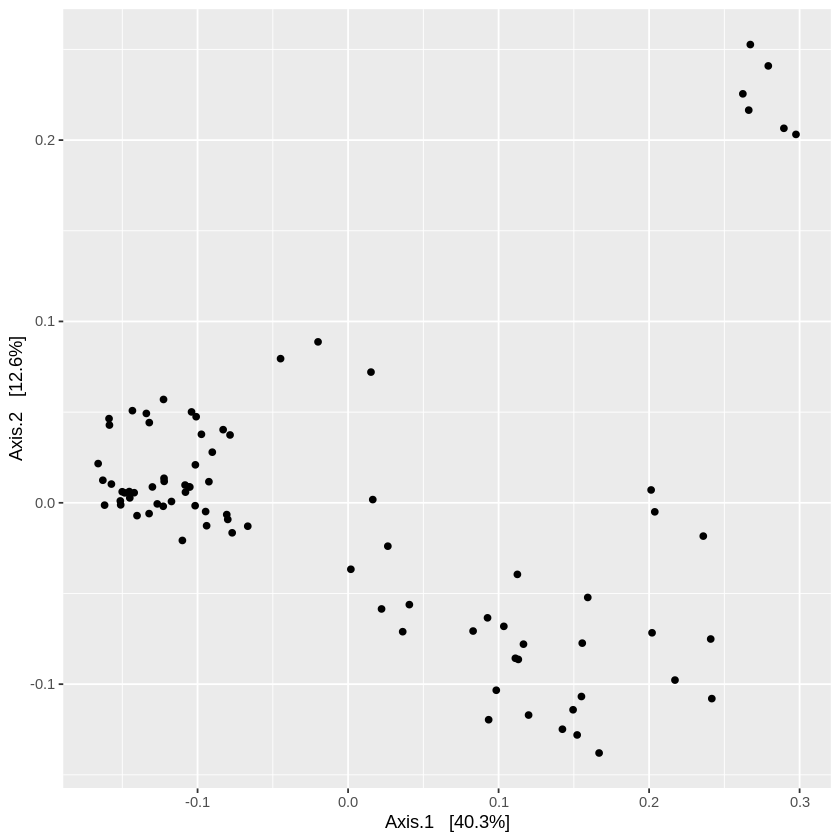

In [9]:
ordu = ordinate(ps.s, "PCoA", "unifrac", weighted=TRUE)
p = plot_ordination(ps.s, ordu, justDF = TRUE)
plot_ordination(ps.s, ordu)

png 
  2

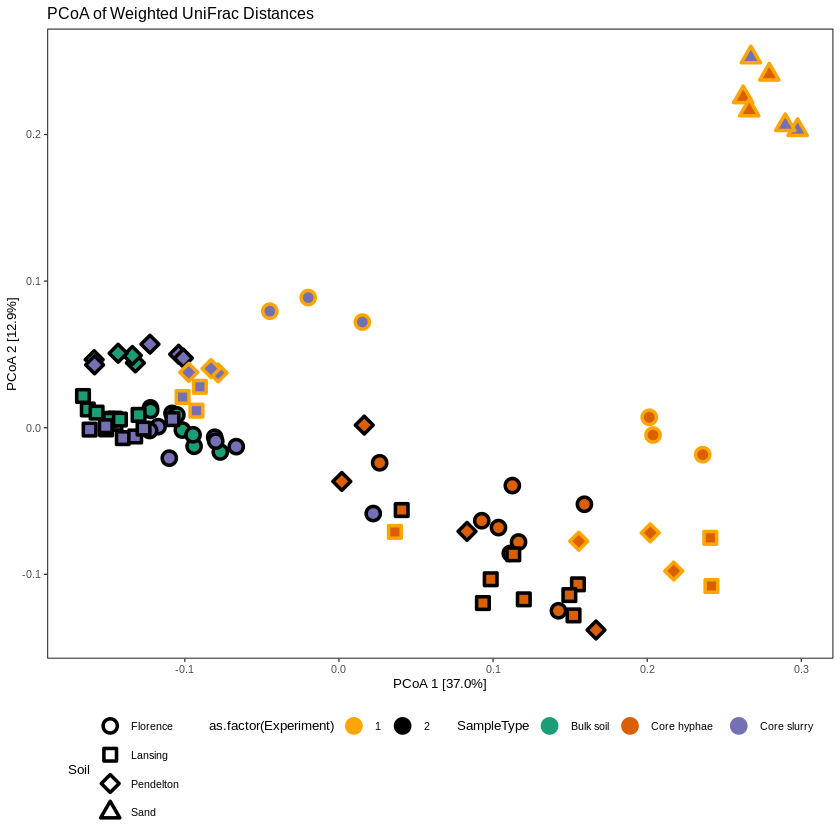

In [10]:
#setwd(figDir)
cs = brewer.pal(3,"Dark2")
p1 = ggplot(p, aes(x = Axis.1, y = Axis.2)) +
geom_point(aes(shape = as.factor(Soil), fill = SampleType, color = as.factor(Experiment)),  size = 3, stroke = 1.5) +
theme_pub() +
scale_shape_manual(values=c(21,22,23,24), guide = guide_legend(title = "Soil", ncol = 1))+
scale_color_manual(values=c('Orange','Black'))+
scale_fill_manual(values = cs, labels = c("Bulk soil", "Core hyphae", "Core slurry"))+
labs(x = "PCoA 1 [37.0%]", y = "PCoA 2 [12.9%]") +
ggtitle("PCoA of Weighted UniFrac Distances")+
#facet_wrap(~Experiment, ncol = 2)

guides(fill=guide_legend(override.aes=list(colour= cs), ncol = 3)) + 
theme(legend.position="bottom") 

#color = "grey20",

p1

pdf(file.path(figDir,"Exp1-2_wUnif_PCOA_BSCHCS.pdf"), useDingbats = FALSE, width = 4.5, height = 4.5)
p1
dev.off()

# Analysis of hyphal and soil samples without sand

In [11]:
ps.s = ps.snorm %>% subset_samples(Experiment %in% c(1, 2) & SampleType %in% c("CS", "CH", "BS") & Fungus == "Gv" & Soil != "Sand" & Treatment == "HN")

#ps.s = ps.snorm %>% subset_samples(Experiment == 1 & SampleType %in% c("CS", "CH", "BS", "RT") & Fungus == "Gv" & Soil != "Sand" & Treatment == "HN")

In [12]:
wunif.dist = phyloseq::distance(ps.s, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

#unif.dist = phyloseq::distance(ps.snorm, 
#                       method = "unifrac", 
#                       weighted = FALSE,
#                       fast = TRUE, 
#                       parallel = TRUE, 
#                       normalized = FALSE)

In [13]:
set.seed(101)

df = as(sample_data(ps.s), "data.frame")
#df$Rep = as.factor(df$Rep)
#df$TimePoint = as.factor(df$TimePoint)
d = wunif.dist

adonis.w = adonis(formula = d ~Soil + SampleType + SampleType:Soil + Experiment + Experiment:SampleType + Soil:Experiment, df, permutations = 999)
print("weighted-UniFrac")
adonis.w

[1] "weighted-UniFrac"



Call:
adonis(formula = d ~ Soil + SampleType + SampleType:Soil + Experiment +      Experiment:SampleType + Soil:Experiment, data = df, permutations = 999) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

                      Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
Soil                   2    0.4622 0.23110  12.350 0.13930  0.001 ***
SampleType             2    1.3124 0.65621  35.068 0.39554  0.001 ***
Experiment             1    0.2592 0.25923  13.853 0.07813  0.001 ***
Soil:SampleType        4    0.1555 0.03887   2.077 0.04686  0.011 *  
SampleType:Experiment  1    0.0950 0.09495   5.074 0.02862  0.002 ** 
Soil:Experiment        2    0.2665 0.13325   7.121 0.08032  0.001 ***
Residuals             41    0.7672 0.01871         0.23123           
Total                 53    3.3180                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [14]:
tabout = adonis.w$aov.tab
tabout[,2:5] = round(tabout[,2:5], 2)
tabout

,Df,SumsOfSqs,MeanSqs,F.Model,R2,Pr(>F)
Soil,2,0.46,0.23,12.35,0.14,0.001
SampleType,2,1.31,0.66,35.07,0.40,0.001
Experiment,1,0.26,0.26,13.85,0.08,0.001
Soil:SampleType,4,0.16,0.04,2.08,0.05,0.011
SampleType:Experiment,1,0.09,0.09,5.07,0.03,0.002
Soil:Experiment,2,0.27,0.13,7.12,0.08,0.001
Residuals,41,0.77,0.02,NA,0.23,NA
Total,53,3.32,NA,NA,1.00,NA


In [16]:
fileout = file.path(figDir, "ADONIS_Exp1-2_CHCSBS_noSand.csv")
write.table(tabout, file = fileout, sep = ',', row.names = TRUE)

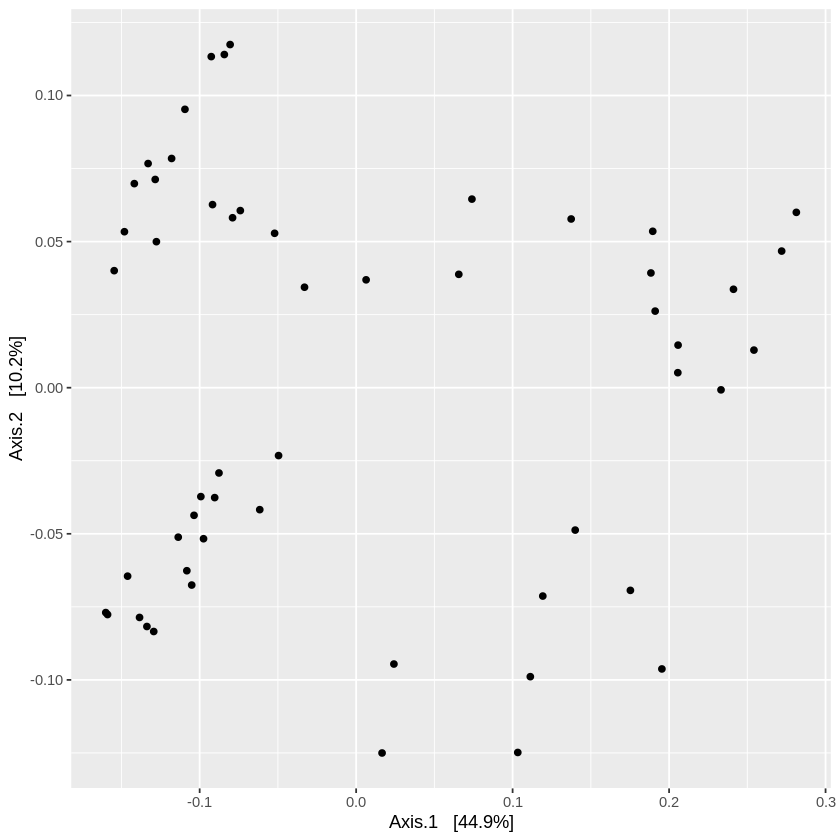

In [17]:
ordu = ordinate(ps.s, "PCoA", "unifrac", weighted=TRUE)
p = plot_ordination(ps.s, ordu, justDF = TRUE)
plot_ordination(ps.s, ordu)

png 
  2

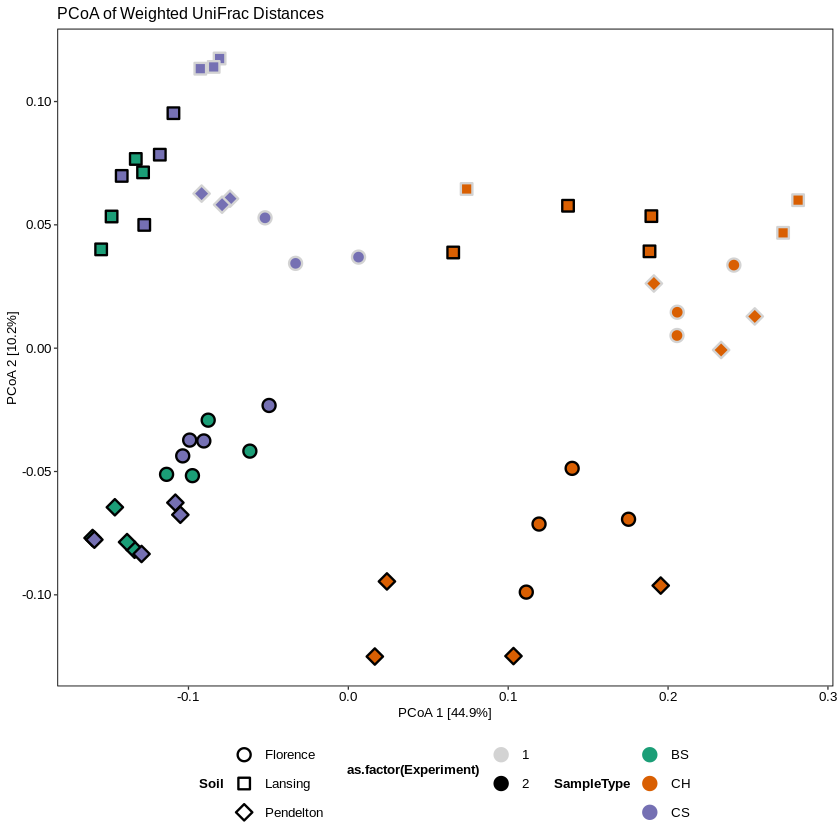

In [32]:
#setwd(figDir)
cs = brewer.pal(3,"Dark2")
p1 = ggplot(p, aes(x = Axis.1, y = Axis.2)) +
geom_point(aes(shape = as.factor(Soil), fill = SampleType, color = as.factor(Experiment)),  size = 3, stroke = 1) +
theme_pub() +
scale_shape_manual(values=c(21,22,23,24), guide = guide_legend(title = "Soil", ncol = 1))+
scale_color_manual(values=c('LightGray','Black'))+
scale_fill_manual(values = cs) + #, labels = c("Bulk soil", "Core hyphae", "Core slurry"))+
labs(x = "PCoA 1 [44.9%]", y = "PCoA 2 [10.2%]") +
ggtitle("PCoA of Weighted UniFrac Distances")+
#facet_wrap(~Experiment, ncol = 2)

guides(fill=guide_legend(override.aes=list(colour= cs), ncol = 1)) + 
guides(color=guide_legend(ncol = 1, fill = "white")) + 
theme(legend.position="bottom") 

#color = "grey20",

p1

pdf(file.path(figDir,"Exp1-2_wUnif_PCOA_BSCHCS_woSand.pdf"), useDingbats = FALSE, width = 3.46, height = 3.06)
p1
dev.off()

## Ordinate hyphal and soil samples and include Ri
* This is not particularly helpful, better to proceed with focused comparison

In [96]:
ps.s = ps.snorm %>% subset_samples(Experiment %in% c(1, 2) & SampleType %in% c("CS", "CH", "BS"))

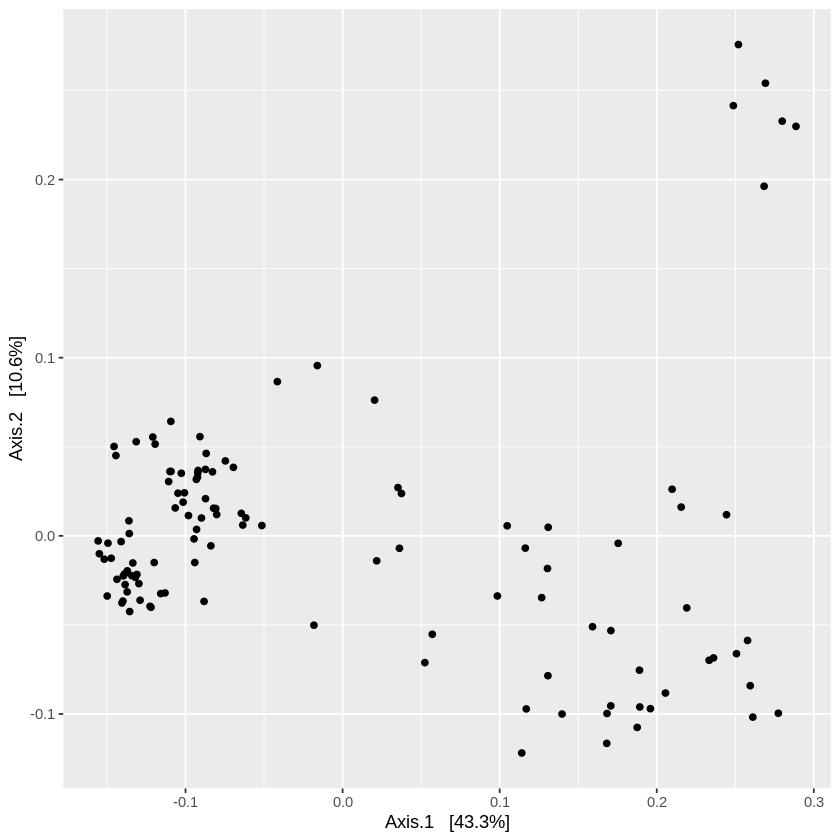

In [97]:
ordu = ordinate(ps.s, "PCoA", "unifrac", weighted=TRUE)
p = plot_ordination(ps.s, ordu, justDF = TRUE)
plot_ordination(ps.s, ordu)

NULL

png 
  2

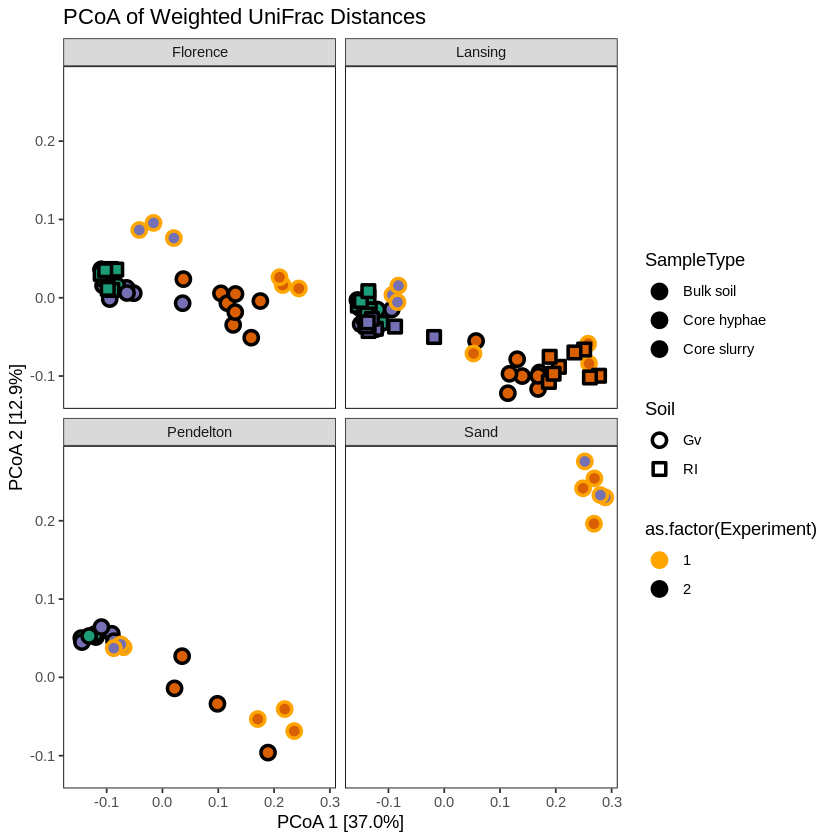

In [98]:
#setwd(figDir)
cs = brewer.pal(3,"Dark2")
p1 = ggplot(p, aes(x = Axis.1, y = Axis.2)) +
geom_point(aes(shape = as.factor(Fungus), fill = SampleType, color = as.factor(Experiment)),  size = 3, stroke = 1.5) +
theme_pub() +
scale_shape_manual(values=c(21,22,23,24), guide = guide_legend(title = "Soil", ncol = 1))+
scale_color_manual(values=c('Orange','Black'))+
scale_fill_manual(values = cs, labels = c("Bulk soil", "Core hyphae", "Core slurry"))+
labs(x = "PCoA 1 [37.0%]", y = "PCoA 2 [12.9%]") +
ggtitle("PCoA of Weighted UniFrac Distances")+
facet_wrap(~Soil, ncol = 2)

guides(fill=guide_legend(override.aes=list(colour= cs), ncol = 3)) + 
theme(legend.position="bottom") 

#color = "grey20",

p1

pdf(file.path(figDir,"Exp1-2_wUnif_PCOA_BSCHCS.pdf"), useDingbats = FALSE, width = 4.5, height = 4.5)
p1
dev.off()

# Subset to just bulk soils and hyphal soils

In [35]:
ps.b = subset_samples(ps.snorm, SampleType %in% c("BS", "BH") & Experiment == 2 & Sample != "GVN7HP4-BH")

In [36]:
b.wunif.dist = phyloseq::distance(ps.b, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                                  
                      normalized = FALSE)

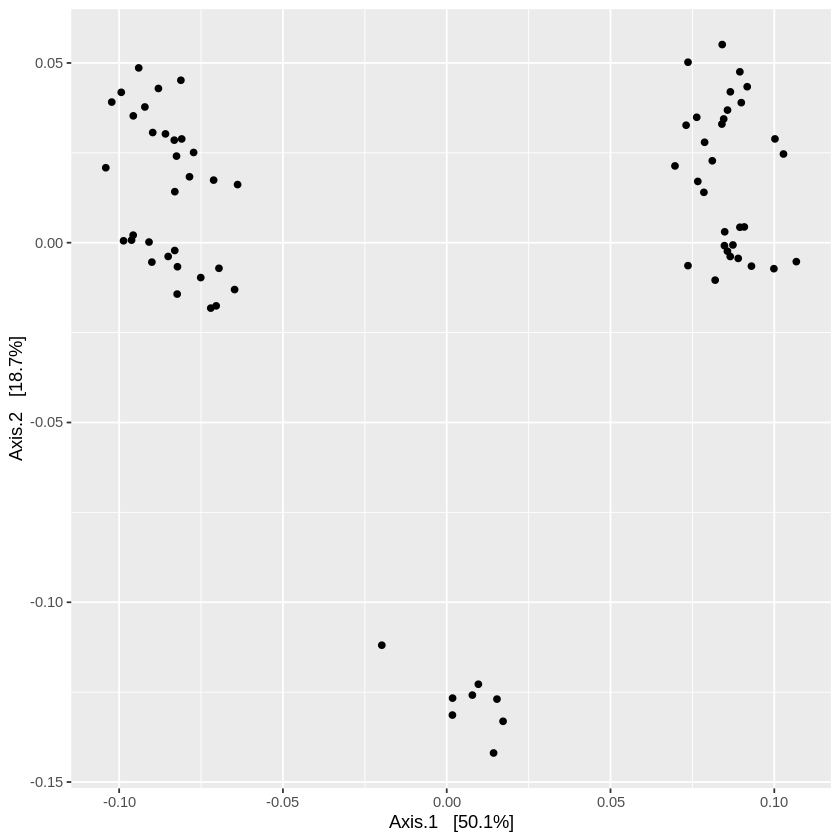

In [37]:
ordu = ordinate(ps.b, "PCoA", "unifrac", weighted=TRUE)
p = plot_ordination(ps.b, ordu, justDF = TRUE)
plot_ordination(ps.b, ordu)

In [38]:
# Check outlier, this is a botched extraction
p %>% filter(Axis.2 > .10)

Axis.1,Axis.2,Sample,Experiment,Plant,Fungus,Soil,SampleType,Treatment,TimePoint,DAI,Rep,Concentration_ng.ul


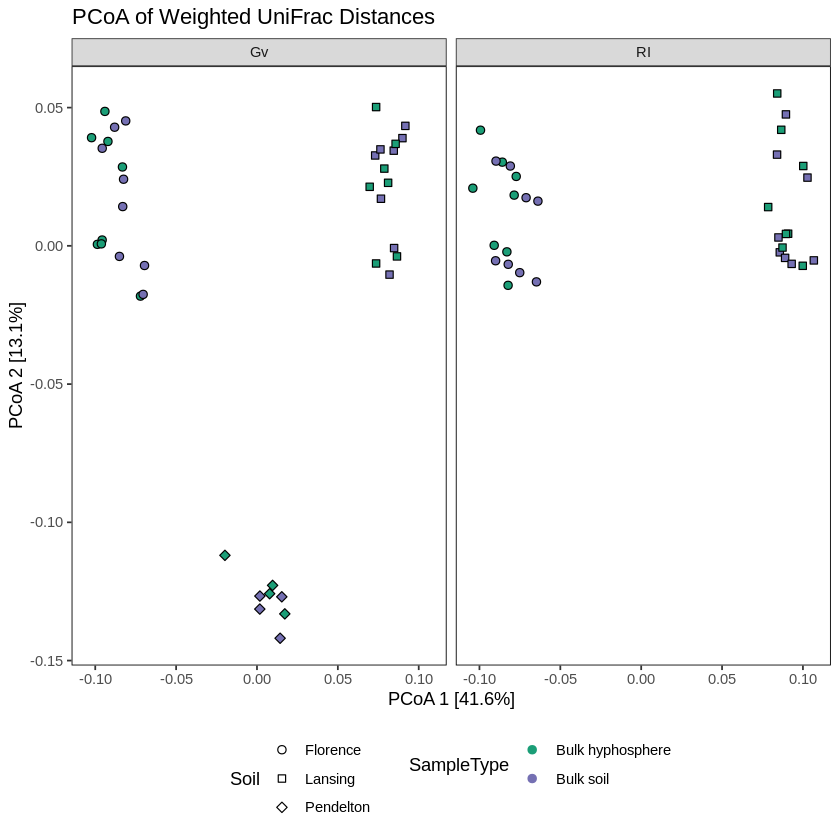

In [39]:
#setwd(figDir)
cs = brewer.pal(7,"Dark2")
p1 = ggplot(p, aes(x = Axis.1, y = Axis.2)) +
geom_point(aes(shape = as.factor(Soil), fill = SampleType),  size = 2) +
theme_pub() +
scale_shape_manual(values=c(21,22,23), guide = guide_legend(title = "Soil", ncol = 1))+
scale_fill_manual(values = cs[c(1,3)], labels = c("Bulk hyphosphere", "Bulk soil"))+
labs(x = "PCoA 1 [41.6%]", y = "PCoA 2 [13.1%]") +
ggtitle("PCoA of Weighted UniFrac Distances")+

guides(fill=guide_legend(override.aes=list(colour= cs[c(1,3)]), ncol = 1)) + 
theme(legend.position="bottom") +
facet_wrap(~Fungus, ncol = 2)

#color = "grey20",

p1

#pdf(file.path(figDir,"wUnif_PCOA_BSBH.pdf"), useDingbats = FALSE, width = 4.5, height = 3)
#p1
#dev.off()

In [40]:
set.seed(101)

df = as(sample_data(ps.b), "data.frame")
#df$Rep = as.factor(df$Rep)
#df$TimePoint = as.factor(df$TimePoint)
d = b.wunif.dist

b.adonis.w = adonis(formula = d ~ Rep + Soil + SampleType + Soil:SampleType + Fungus + Fungus:SampleType, df, permutations = 999)
print("weighted-UniFrac")
b.adonis.w

# d = unif.dist
# #Soiladonis = adonis(formula = d ~ Planted + DAP + Plant + Treatment, df, strata = df$Rep:df$Plant, permutations = 999)
# adonis.u = adonis(formula = d ~ Rep + SampleType + TimePoint + SampleType:TimePoint, df, permutations = 999)
# print("unweighted-UniFrac")
#adonis.u

[1] "weighted-UniFrac"



Call:
adonis(formula = d ~ Rep + Soil + SampleType + Soil:SampleType +      Fungus + Fungus:SampleType, data = df, permutations = 999) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

                  Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
Rep                1   0.03484 0.03484   6.471 0.02942  0.001 ***
Soil               2   0.77744 0.38872  72.201 0.65648  0.001 ***
SampleType         1   0.01482 0.01482   2.752 0.01251  0.032 *  
Fungus             1   0.01301 0.01301   2.417 0.01099  0.055 .  
Soil:SampleType    2   0.00665 0.00332   0.617 0.00561  0.749    
SampleType:Fungus  1   0.00371 0.00371   0.688 0.00313  0.556    
Residuals         62   0.33380 0.00538         0.28186           
Total             70   1.18426                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

# Additional controls

In [45]:
ps.s = ps.snorm %>% subset_samples(Experiment == 2 & Fungus == "Gv")

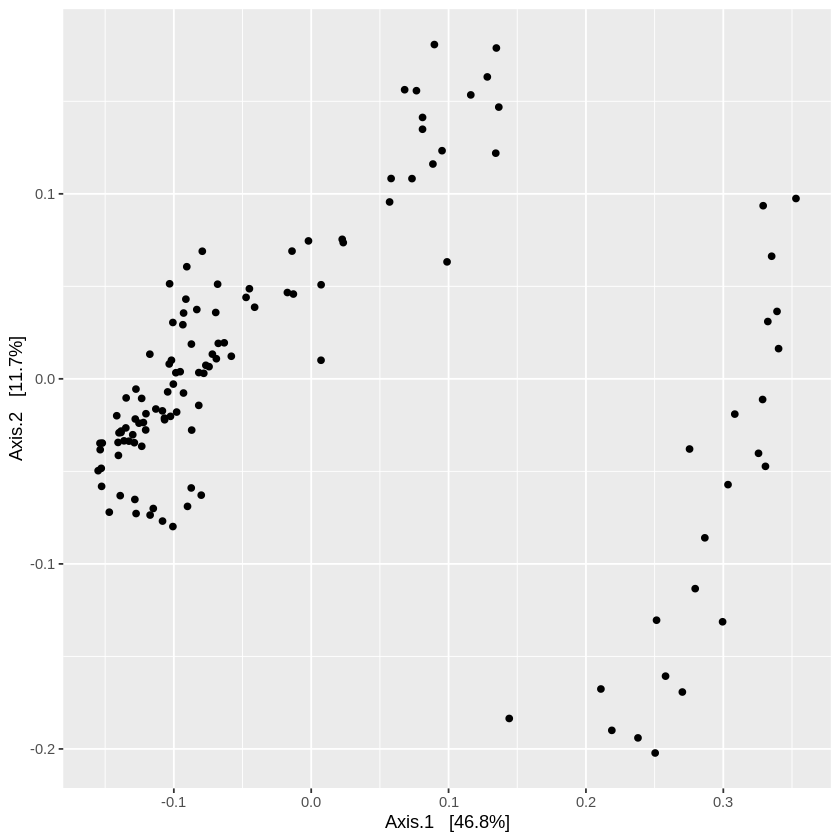

In [46]:
ordu = ordinate(ps.s, "PCoA", "unifrac", weighted=TRUE)
p = plot_ordination(ps.s, ordu, justDF = TRUE)
plot_ordination(ps.s, ordu)

In [50]:
brewer.pal(7,"Dark2")

cs = c('#66a61e', #BH
       '#e7298a', #BP
       '#1b9e77', #BS
       
        '#d95f02', #CH, 
       '#7570b3', #CS,
       "#e6ab02", #RH
       "#a6761d") #RS

[1] "#1B9E77" "#D95F02" "#7570B3" "#E7298A" "#66A61E" "#E6AB02" "#A6761D"

png 
  2

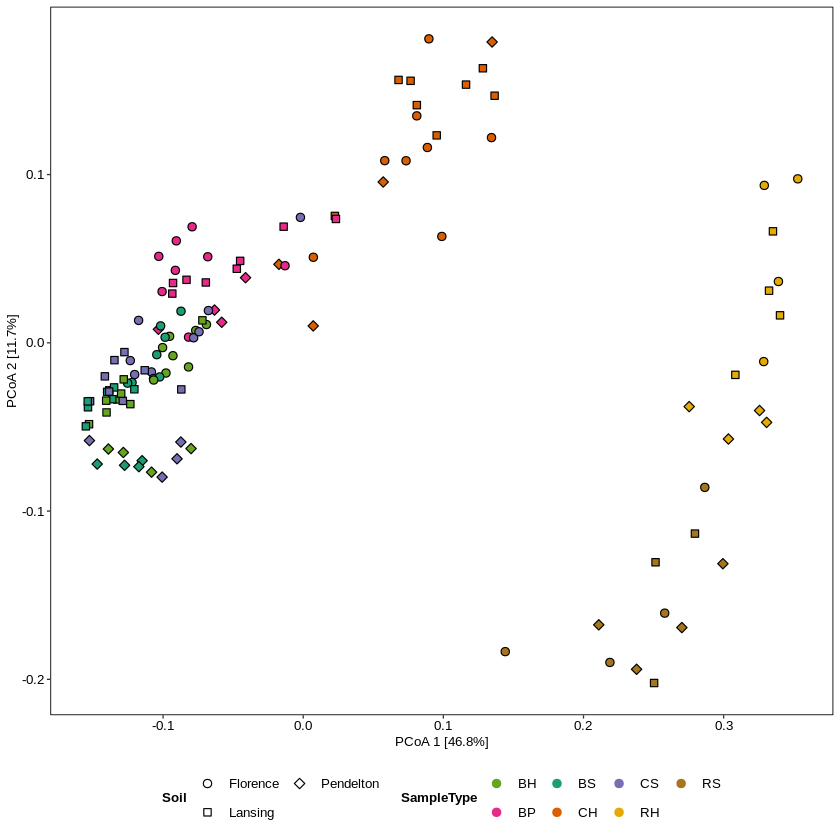

In [52]:


p1 = ggplot(p, aes(x = Axis.1, y = Axis.2)) +
geom_point(aes(shape = Soil, fill = SampleType),  size = 2) +
theme_pub() +
scale_shape_manual(values=c(21,22,23), guide = guide_legend(title = "Soil", ncol = 2))+
scale_fill_manual(values = cs)+
labs(x = "PCoA 1 [46.8%]", y = "PCoA 2 [11.7%]") +
#ggtitle("PCoA of Weighted UniFrac Distances")+

guides(fill=guide_legend(override.aes=list(colour= cs), ncol = 4)) + 
theme(legend.position="bottom") 

#color = "grey20",

p1

pdf(file = file.path(figDir,'Exp2_FullOrdination.pdf'), width = 7.086, height = 5, useDingbats = FALSE)
p1
dev.off()


# Does fungal species matter

In [38]:
ps.s = subset_samples(ps.snorm, SampleType %in% c("BS","CS","CH") & Soil == "Lansing" & Experiment == 2)

In [39]:
sample_data(ps.s) %>% head()

,Sample,Experiment,Plant,Fungus,Soil,SampleType,Treatment,TimePoint,DAI,Rep,Concentration_ng.ul
GVN7HN1-BS,GVN7HN1-BS,2,GVN7HN1,Gv,Lansing,BS,HN,NA,27,1,NA
GVN7HN1-CH,GVN7HN1-CH,2,GVN7HN1,Gv,Lansing,CH,HN,NA,27,1,NA
GVN7HN1-CS,GVN7HN1-CS,2,GVN7HN1,Gv,Lansing,CS,HN,NA,27,1,NA
GVN7HN2-BS,GVN7HN2-BS,2,GVN7HN2,Gv,Lansing,BS,HN,NA,27,2,NA
GVN7HN2-CH,GVN7HN2-CH,2,GVN7HN2,Gv,Lansing,CH,HN,NA,27,2,NA
GVN7HN2-CS,GVN7HN2-CS,2,GVN7HN2,Gv,Lansing,CS,HN,NA,27,2,NA


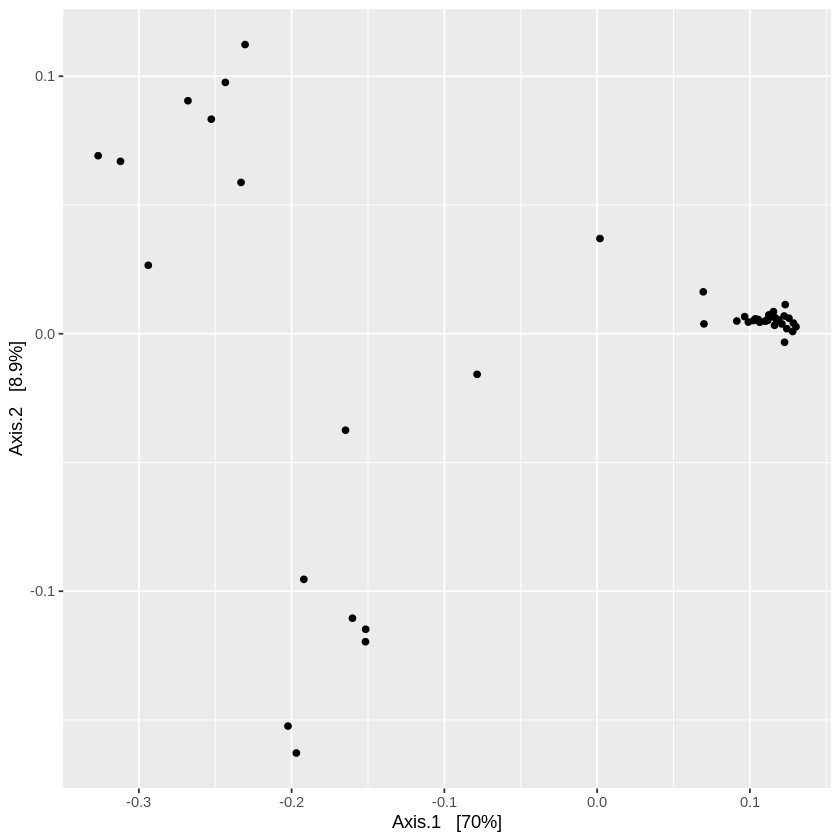

In [40]:
ordu = ordinate(ps.s, "PCoA", "unifrac", weighted=TRUE)
p = plot_ordination(ps.s, ordu, justDF = TRUE)
plot_ordination(ps.s, ordu)

In [41]:
head(p)

,Axis.1,Axis.2,Sample,Experiment,Plant,Fungus,Soil,SampleType,Treatment,TimePoint,DAI,Rep,Concentration_ng.ul
GVN7HN1-BS,0.1255681,0.006033579,GVN7HN1-BS,2,GVN7HN1,Gv,Lansing,BS,HN,NA,27,1,NA
GVN7HN1-CH,-0.0785735,-0.015768095,GVN7HN1-CH,2,GVN7HN1,Gv,Lansing,CH,HN,NA,27,1,NA
GVN7HN1-CS,0.1064014,0.004466935,GVN7HN1-CS,2,GVN7HN1,Gv,Lansing,CS,HN,NA,27,1,NA
GVN7HN2-BS,0.1099144,0.004826174,GVN7HN2-BS,2,GVN7HN2,Gv,Lansing,BS,HN,NA,27,2,NA
GVN7HN2-CH,-0.1601740,-0.110485151,GVN7HN2-CH,2,GVN7HN2,Gv,Lansing,CH,HN,NA,27,2,NA
GVN7HN2-CS,0.1241882,0.001974033,GVN7HN2-CS,2,GVN7HN2,Gv,Lansing,CS,HN,NA,27,2,NA


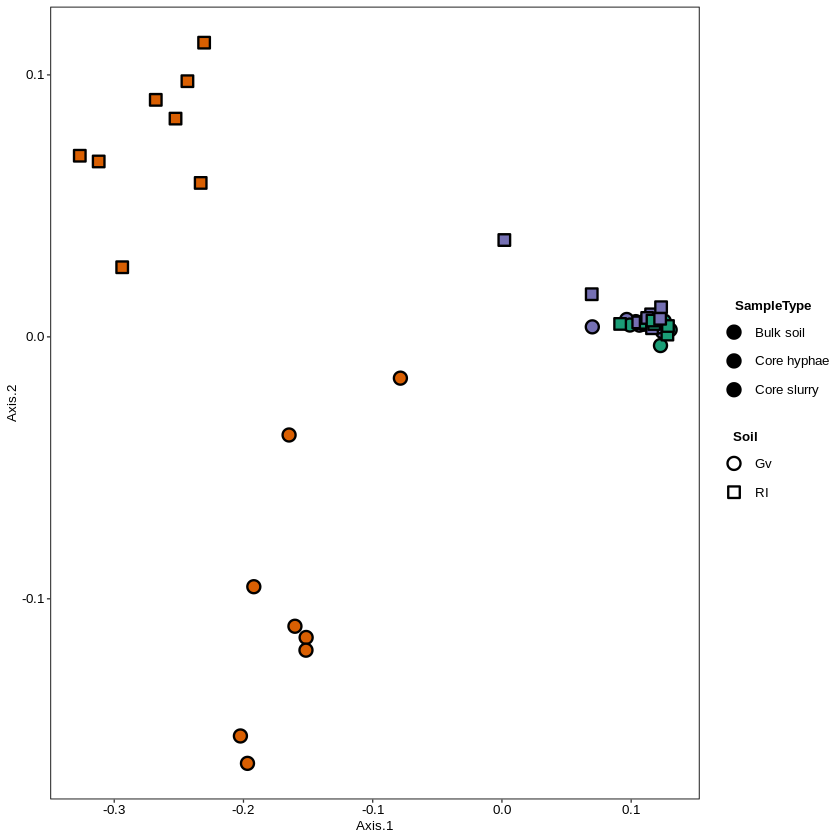

In [42]:
cs = brewer.pal(3,"Dark2")
ggplot(p, aes(x = Axis.1, y = Axis.2, fill = SampleType, shape = Fungus))+
geom_point(size = 3, stroke = 1) +
theme_pub() +
scale_shape_manual(values=c(21,22,23,24), guide = guide_legend(title = "Soil", ncol = 1))+
scale_color_manual(values=c('Orange','Black'))+
scale_fill_manual(values = cs, labels = c("Bulk soil", "Core hyphae", "Core slurry"))

png 
  2

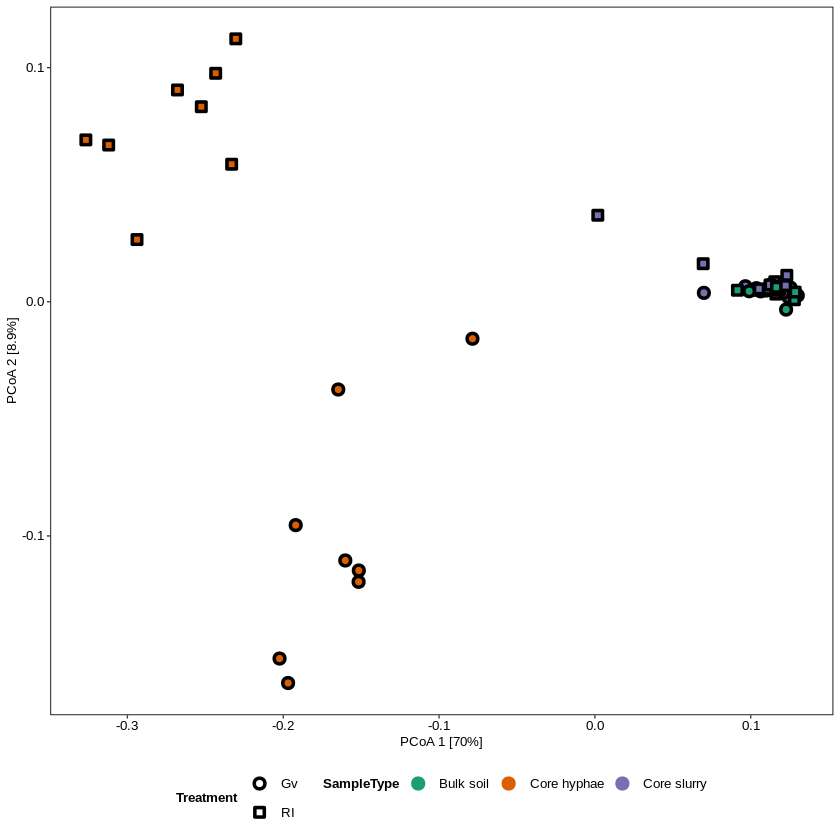

In [43]:
cs = brewer.pal(3,"Dark2")
p1 = ggplot(p, aes(x = Axis.1, y = Axis.2)) +
geom_point(aes(shape = as.factor(Fungus), fill = SampleType),  size = 2, stroke = 1.5) +
theme_pub() +
scale_shape_manual(values=c(21,22), guide = guide_legend(title = "Treatment", ncol = 1))+
scale_fill_manual(values = cs, labels = c("Bulk soil", "Core hyphae", "Core slurry"))+
labs(x = "PCoA 1 [70%]", y = "PCoA 2 [8.9%]") +

guides(fill=guide_legend(override.aes=list(colour= cs, ncol = 1))) + 
theme(legend.position="bottom")

#color = "grey20",

p1
pf = p1
pdf(file.path(figDir,"wUnif_PCOA_CHCSxFungus.pdf"), useDingbats = FALSE, width = 3.14, height = 3)
p1
dev.off()
rm(p1)

In [60]:
s.wunif.dist = phyloseq::distance(ps.s, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [61]:
### set.seed(101)

df = as(sample_data(ps.s), "data.frame")
#df$Rep = as.factor(df$Rep)
#df$TimePoint = as.factor(df$TimePoint)
d = s.wunif.dist

s.adonis.w = adonis(formula = d ~ as.factor(Rep) + SampleType + Fungus + Fungus:SampleType, df, permutations = 999)
print("weighted-UniFrac")
s.adonis.w

[1] "weighted-UniFrac"



Call:
adonis(formula = d ~ as.factor(Rep) + SampleType + Fungus + Fungus:SampleType,      data = df, permutations = 999) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

                  Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
as.factor(Rep)     3   0.07908 0.02636   2.827 0.03486  0.015 *  
SampleType         2   1.54641 0.77321  82.908 0.68160  0.001 ***
Fungus             1   0.10364 0.10364  11.112 0.04568  0.002 ** 
SampleType:Fungus  2   0.17596 0.08798   9.434 0.07755  0.001 ***
Residuals         39   0.36372 0.00933         0.16031           
Total             47   2.26881                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [62]:
tabout = s.adonis.w$aov.tab
tabout[,2:5] = round(tabout[,2:5], 2)
tabout
fileout = file.path(figDir, "ADONIS_Exp2_FungalSpecies.csv")
write.table(tabout, file = fileout, sep = ',', row.names = TRUE)

,Df,SumsOfSqs,MeanSqs,F.Model,R2,Pr(>F)
as.factor(Rep),3,0.08,0.03,2.83,0.03,0.015
SampleType,2,1.55,0.77,82.91,0.68,0.001
Fungus,1,0.10,0.10,11.11,0.05,0.002
SampleType:Fungus,2,0.18,0.09,9.43,0.08,0.001
Residuals,39,0.36,0.01,NA,0.16,NA
Total,47,2.27,NA,NA,1.00,NA


# Just core hyphae, treatment effects

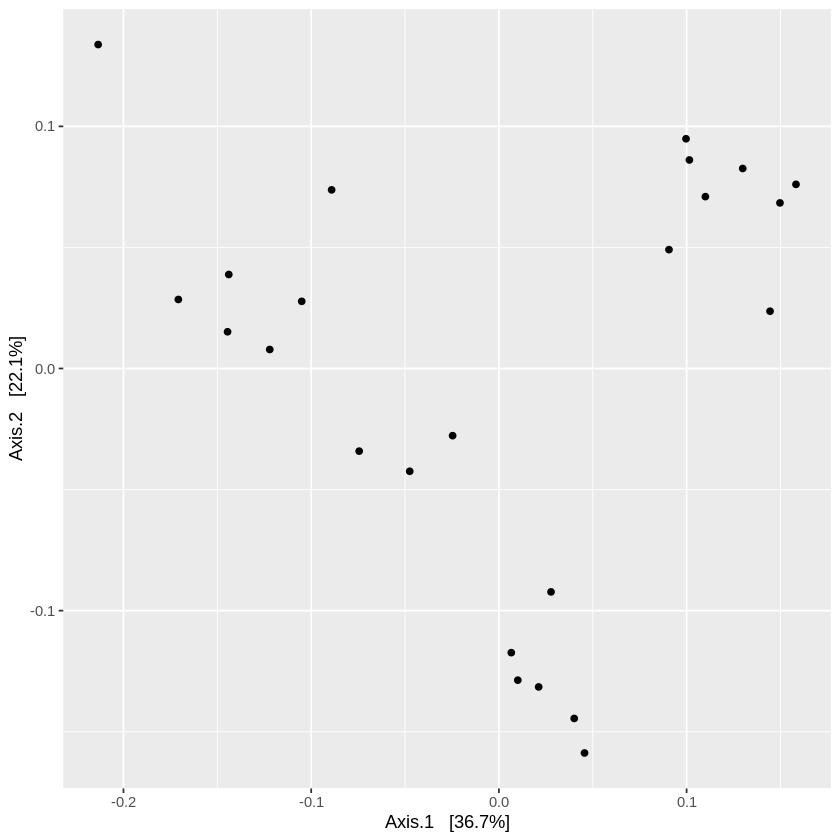

In [5]:
ps.b = subset_samples(ps.snorm, SampleType %in% c("CH") & Soil != "Pendelton" & Experiment == 2)
ordu = ordinate(ps.b, "PCoA", "unifrac", weighted=TRUE)
p = plot_ordination(ps.b, ordu, justDF = TRUE)
plot_ordination(ps.snorm, ordu)

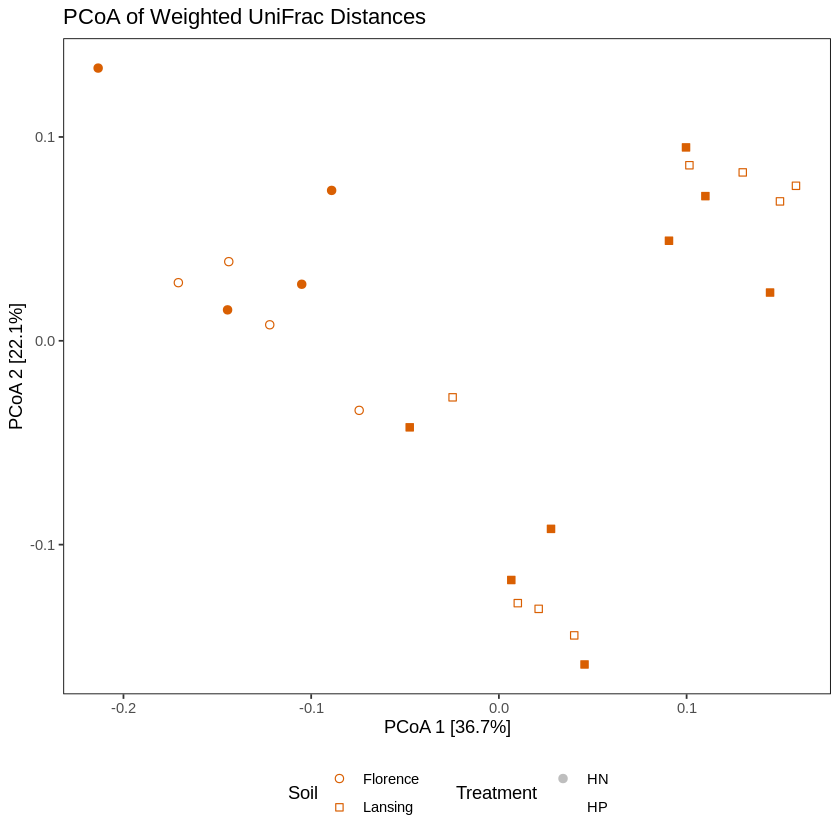

In [22]:
cs = brewer.pal(3,"Dark2")[2]
p1 = ggplot(p, aes(x = Axis.1, y = Axis.2)) +
geom_point(aes(fill = Treatment, shape = Soil),  size = 2, color = cs) +
theme_pub() +
scale_shape_manual(values=c(21,22,23,24), guide = guide_legend(title = "Soil", ncol = 1))+
scale_fill_manual(values = c(cs, "White"))+
labs(x = "PCoA 1 [36.7%]", y = "PCoA 2 [22.1%]") +
ggtitle("PCoA of Weighted UniFrac Distances")+

guides(fill=guide_legend(override.aes=list(color= c("Grey", "White")), ncol = 1)) + 
theme(legend.position="bottom")
#facet_wrap(Fungus~Soil, ncol = 2)

#color = "grey20",

p1



In [7]:
b.wunif.dist = phyloseq::distance(ps.b, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [20]:
df = as(sample_data(ps.b), "data.frame")
#df$Rep = as.factor(df$Rep)
#df$TimePoint = as.factor(df$TimePoint)
d = b.wunif.dist

b.adonis.w = adonis(formula = d ~ as.factor(Rep) + Soil + Fungus + Treatment + Treatment:Fungus + Treatment:Soil, df, permutations = 999)
print("weighted-UniFrac")
b.adonis.w
Atab = b.adonis.w$aov %>% as.data.frame()
Atab[,2:5] = round(Atab[,2:5], digits=2) 
Atab = Atab %>% select(-SumsOfSqs)
Atab


[1] "weighted-UniFrac"



Call:
adonis(formula = d ~ as.factor(Rep) + Soil + Fungus + Treatment +      Treatment:Fungus + Treatment:Soil, data = df, permutations = 999) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

                 Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
as.factor(Rep)    3   0.12503 0.04168  1.7405 0.10431  0.058 .  
Soil              1   0.36246 0.36246 15.1371 0.30240  0.001 ***
Fungus            1   0.26145 0.26145 10.9187 0.21813  0.001 ***
Treatment         1   0.02688 0.02688  1.1226 0.02243  0.317    
Fungus:Treatment  1   0.02554 0.02554  1.0665 0.02131  0.352    
Soil:Treatment    1   0.03808 0.03808  1.5903 0.03177  0.138    
Residuals        15   0.35918 0.02395         0.29966           
Total            23   1.19861                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

,Df,MeanSqs,F.Model,R2,Pr(>F)
as.factor(Rep),3,0.04,1.74,0.10,0.058
Soil,1,0.36,15.14,0.30,0.001
Fungus,1,0.26,10.92,0.22,0.001
Treatment,1,0.03,1.12,0.02,0.317
Fungus:Treatment,1,0.03,1.07,0.02,0.352
Soil:Treatment,1,0.04,1.59,0.03,0.138
Residuals,15,0.02,NA,0.30,NA
Total,23,NA,NA,1.00,NA


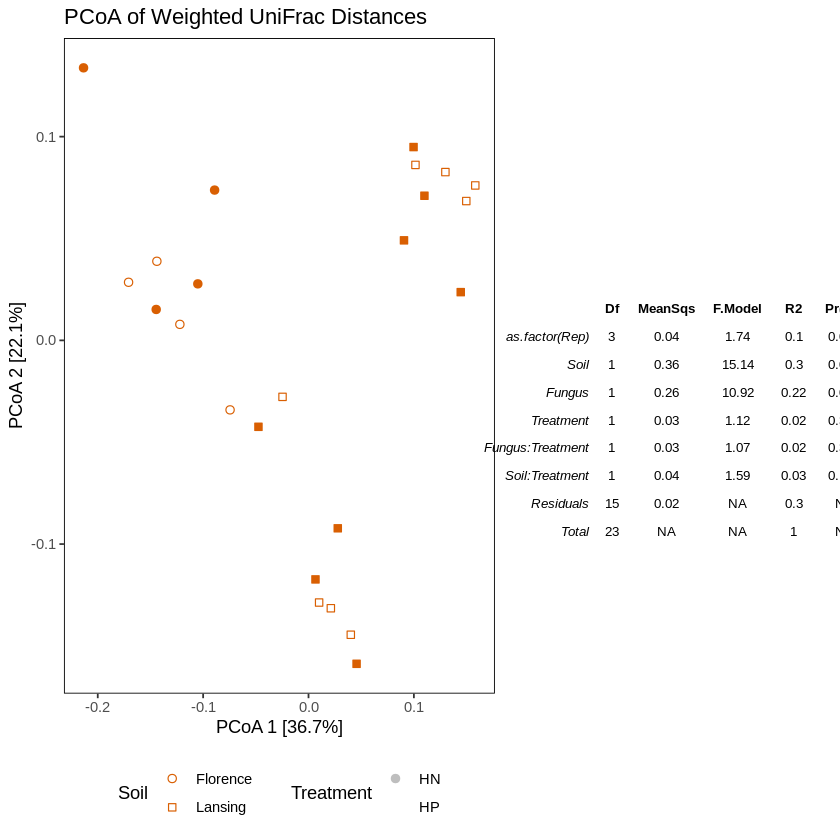

In [23]:
pm1 = ggtexttable(Atab, theme = ttheme("blank", base_size = 8))
ggarrange(p1, pm1, ncol = 2, widths = c(1.5, 1))

In [24]:
pdf(file.path(figDir,"wUnif_PCOA_CHxTreatment.pdf"), useDingbats = FALSE, width = 7.31, height = 4)
ggarrange(p1, pm1, ncol = 2)
dev.off()

png 
  2

### Try Bray-curtis

In [31]:
b.bray.dist = phyloseq::distance(ps.b, 
                      method = "bray", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [32]:
df = as(sample_data(ps.b), "data.frame")
#df$Rep = as.factor(df$Rep)
#df$TimePoint = as.factor(df$TimePoint)
d = b.wunif.dist

b.bray.w = adonis(formula = d ~ as.factor(Rep) + Soil + Fungus + Treatment + Treatment:Fungus + Treatment:Soil, df, permutations = 999)
print("Bray-Curtis")
b.bray.w

[1] "Bray-Curtis"



Call:
adonis(formula = d ~ as.factor(Rep) + Soil + Fungus + Treatment +      Treatment:Fungus + Treatment:Soil, data = df, permutations = 999) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

                 Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
as.factor(Rep)    3   0.12503 0.04168  1.7405 0.10431  0.045 *  
Soil              1   0.36246 0.36246 15.1371 0.30240  0.001 ***
Fungus            1   0.26145 0.26145 10.9187 0.21813  0.001 ***
Treatment         1   0.02688 0.02688  1.1226 0.02243  0.314    
Fungus:Treatment  1   0.02554 0.02554  1.0665 0.02131  0.342    
Soil:Treatment    1   0.03808 0.03808  1.5903 0.03177  0.143    
Residuals        15   0.35918 0.02395         0.29966           
Total            23   1.19861                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [ ]:
* Treatment not a significant predictor

In [57]:
rm(ps.b)

# Changes with time

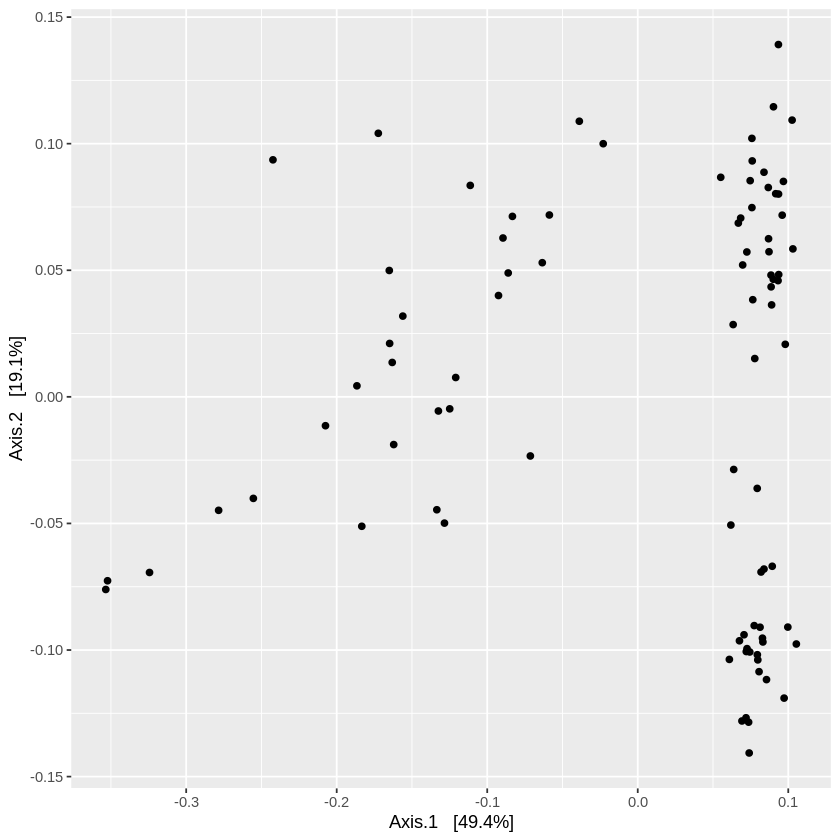

In [31]:
ps.t = subset_samples(ps.snorm, SampleType %in% c("CH", "CS", "BS") & Experiment == 3)
ordu = ordinate(ps.t, "PCoA", "unifrac", weighted=TRUE)
p = plot_ordination(ps.t, ordu, justDF = TRUE)
plot_ordination(ps.snorm, ordu)

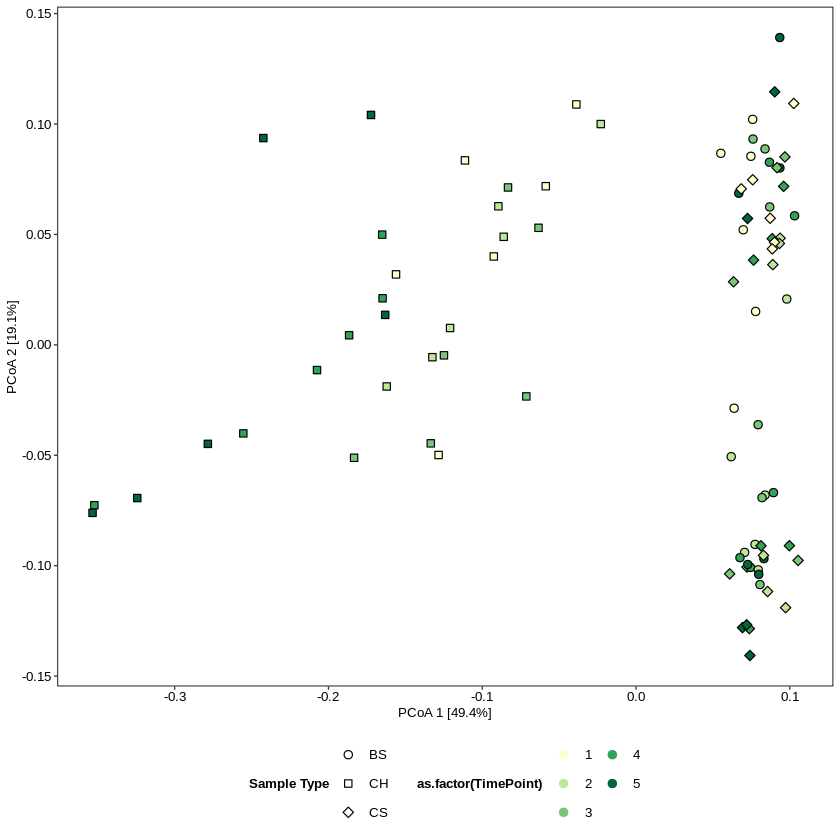

In [33]:
cs = brewer.pal(5,"YlGn")
p1 = ggplot(p, aes(x = Axis.1, y = Axis.2)) +
geom_point(aes(shape = as.factor(SampleType), fill = as.factor(TimePoint)),  size = 2) +
theme_pub() +
scale_shape_manual(values=c(21,22,23), guide = guide_legend(title = "Sample Type", ncol = 1))+
scale_fill_manual(values = cs)+
labs(x = "PCoA 1 [49.4%]", y = "PCoA 2 [19.1%]") +

guides(fill=guide_legend(override.aes=list(colour= cs), ncol = 2)) + 
theme(legend.position="bottom") 
p1
pt = p1

In [34]:
pdf(file.path(figDir,"wUnif_PCOA_time.pdf"), useDingbats = FALSE, width = 3.14, height = 3)
p1
dev.off()
rm(p1)

png 
  2

In [35]:
t.wunif.dist = phyloseq::distance(ps.t, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [36]:
df = as(sample_data(ps.t), "data.frame")
#df$Rep = as.factor(df$Rep)
#df$TimePoint = as.factor(df$TimePoint)
d = t.wunif.dist

t.adonis.w = adonis(formula = d ~ as.factor(Rep) + SampleType + as.factor(DAI) + as.factor(DAI):SampleType , df, permutations = 999)
print("weighted-UniFrac")
t.adonis.w

[1] "weighted-UniFrac"



Call:
adonis(formula = d ~ as.factor(Rep) + SampleType + as.factor(DAI) +      as.factor(DAI):SampleType, data = df, permutations = 999) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

                          Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
as.factor(Rep)             5    0.4223 0.08447   5.715 0.12112  0.001 ***
SampleType                 2    1.4793 0.73964  50.045 0.42425  0.001 ***
as.factor(DAI)             4    0.2711 0.06776   4.585 0.07774  0.001 ***
SampleType:as.factor(DAI)  8    0.3092 0.03865   2.615 0.08867  0.001 ***
Residuals                 68    1.0050 0.01478         0.28823           
Total                     87    3.4869                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [40]:
tabout = t.adonis.w$aov.tab
tabout[,2:5] = round(tabout[,2:5], 2)
tabout



,Df,SumsOfSqs,MeanSqs,F.Model,R2,Pr(>F)
as.factor(Rep),5,0.42,0.08,5.72,0.12,0.001
SampleType,2,1.48,0.74,50.05,0.42,0.001
as.factor(DAI),4,0.27,0.07,4.58,0.08,0.001
SampleType:as.factor(DAI),8,0.31,0.04,2.61,0.09,0.001
Residuals,68,1.01,0.01,NA,0.29,NA
Total,87,3.49,NA,NA,1.00,NA


In [41]:
fileout = file.path(figDir, "ADONIS_Exp3_CHCSBS.csv")
write.table(tabout, file = fileout, sep = ',', row.names = TRUE)

# Multipanel for publication


In [44]:
require(cowplot)

pdf(file.path(figDir,"MultPanel2_a-b.pdf"), useDingbats = FALSE, width = 7.086, height = 3.3)
plot_grid(pf, pt, ncol = 2, align = "h")
dev.off()

png 
  2